In [20]:
import os
import shutil
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gwosc.timeline import get_segments
from gwpy.timeseries import TimeSeries
from lalframe.utils import frtools

### Fetch Open Data


In [21]:
ifo = "L1"
sample_rate = 4096
format = "gwf"
O3b_start = 1256655618
O3b_end = 1269363618

# Searching for the available segments
L1_segments = get_segments(
    f"{ifo}_DATA",
    start=O3b_start,
    end=O3b_end,
)
seg_id = 0
chosen_seg = L1_segments[seg_id]
print(f"Chosen segment: {chosen_seg}")
print(f"Length of segment {seg_id}: {chosen_seg[1] - chosen_seg[0]}")

# Create folders
root_dir = f"/home/jerry/GW/glitch-classification"
working_dir = f"{root_dir}/Omicron"
data_dir = f"{root_dir}/Data"
output_dir = f"{working_dir}/triggers"
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Fetch time series data
# print(f"Fetching {ifo} Data: {chosen_seg[0]} s to {chosen_seg[1]} s.")
# ts = TimeSeries.fetch_open_data(
#     ifo=ifo,
#     start=chosen_seg[0],
#     end=chosen_seg[1],
#     sample_rate=sample_rate,
#     format=format,
# )

# Save time series data for Omicron analysis
gwf_file = f"{data_dir}/{ifo[0]}-{ifo}_GWOSC_O3b_4KHZ_R1-{chosen_seg[0]}-{chosen_seg[1]-chosen_seg[0]}.gwf"
# ts.write(gwf_file, format=format)
# print(f"Data written to {gwf_file}.")

Chosen segment: (1256655666, 1256657739)
Length of segment 0: 2073


### Run Omicron

In [22]:
start = chosen_seg[0]
end = chosen_seg[1]
# Get channel name from the downloaded data
channel = frtools.get_channels(gwf_file)[0]
print(f"Channel name: {channel}")

Channel name: L1:GWOSC-4KHZ_R1_STRAIN


In [6]:
# Generating lcf file
os.chdir(working_dir)
lcf_content = f"{ifo} {channel} {start} {end-start} {gwf_file}"
lcf_file = f"{working_dir}/frames.lcf"
with open(lcf_file, 'w') as file:
    file.write(lcf_content)

# Generating parameters.txt
parameter_content = f"""\
# Omicron parameter file

PARAMETER CLUSTERING       TIME
PARAMETER FFTPLAN          FFTW_ESTIMATE
PARAMETER TRIGGERRATEMAX   100000
PARAMETER QRANGE           3.3166 108.0
PARAMETER FREQUENCYRANGE   32.0 2048.0
PARAMETER CLUSTERDT        0.5
PARAMETER MISMATCHMAX      0.2
PARAMETER SNRTHRESHOLD     5.0 
PARAMETER PSDLENGTH        124
PARAMETER TIMING           64 4

OUTPUT    DIRECTORY        {output_dir}
OUTPUT    PRODUCTS         triggers
OUTPUT    VERBOSITY        1
OUTPUT    FORMAT           hdf5
OUTPUT    NTRIGGERMAX      10000000.0

DATA      SAMPLEFREQUENCY  1024
DATA      FFL              {lcf_file}
DATA      CHANNELS         {channel}
"""
parameter_file = f"{working_dir}/parameters.txt"
with open(parameter_file, 'w') as file:
    file.write(parameter_content)

In [7]:
# Run Omicron
os.chdir(working_dir)
if os.path.exists(f"{output_dir}/{channel}"):
    shutil.rmtree(f"{output_dir}/{channel}")
os.system(f"omicron {start} {end} {parameter_file} strict")
os.system(f"rm {output_dir}/*.ffl")
os.chdir(root_dir)

C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/home/jerry/miniforge3/envs/glitch-classification/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~




##############################################################
##############################################################

   ██████╗ ███╗   ███╗██╗ ██████╗██████╗  ██████╗ ███╗   ██╗
  ██╔═══██╗████╗ ████║██║██╔════╝██╔══██╗██╔═══██╗████╗  ██║
  ██║   ██║██╔████╔██║██║██║     ██████╔╝██║   ██║██╔██╗ ██║
  ██║   ██║██║╚██╔╝██║██║██║     ██╔══██╗██║   ██║██║╚██╗██║
  ╚██████╔╝██║ ╚═╝ ██║██║╚██████╗██║  ██║╚██████╔╝██║ ╚████║
   ╚═════╝ ╚═╝     ╚═╝╚═╝ ╚═══��═╝╚═╝  ╚═╝ ╚═════╝ ╚═╝  ╚═══╝
                                                    4.1.1
##############################################################
##############################################################


IO::ParseFile: Parse file /home/jerry/GW/glitch-classification/Omicron/parameters.txt		ok
Omicron::ReadOptions: number of options = 43
ffl::ffl: detect file format
ffl::Convert2Ffl: FFL conversion
ffl::Reset: reset ffl
ffl::LoadFrameFile: load FFL file
ffl::LoadFrameFile: extract frame information
ffl::LoadFrameFile:

### Gathering triggers

In [23]:
h5s = glob.glob(f"{output_dir}/{channel}/*.h5")
h5s = sorted(h5s)
triggers = []
for h5 in h5s:
    with h5py.File(h5, 'r') as f:
        # Look up for the keys
        # print(f.keys())
        triggers.extend(f['triggers'][:])

print(f"Number of the triggers from {start} to {end}: {len(triggers)}")
# Gather trigger times
trigger_times = [float(trigger['time']) for trigger in triggers]
# Gather trigger frequencies
trigger_frequencies = [float(trigger['frequency']) for trigger in triggers]
# Gather trigger snrs
trigger_snrs = [float(trigger['snr']) for trigger in triggers]

# Save the trigger information
trigger_info = np.stack(triggers)
trigger_info_file = f"{output_dir}/triggers_merge_{channel.replace(':', '_', 1)}-{chosen_seg[1]}-{chosen_seg[1]-chosen_seg[0]}.hdf5"
if os.path.exists(trigger_info_file):
    os.remove(trigger_info_file)
with h5py.File(trigger_info_file, 'w') as f:
    f.create_dataset(
        "triggers",
        shape=trigger_info.shape,
        dtype=trigger_info.dtype,
        data=trigger_info,
    )

Number of the triggers from 1256655666 to 1256657739: 124


### Whiten Time Series Data

/home/jerry/miniforge3/envs/gw-demo/lib/python3.10/site-packages/gwpy/plot/plot.py:297: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


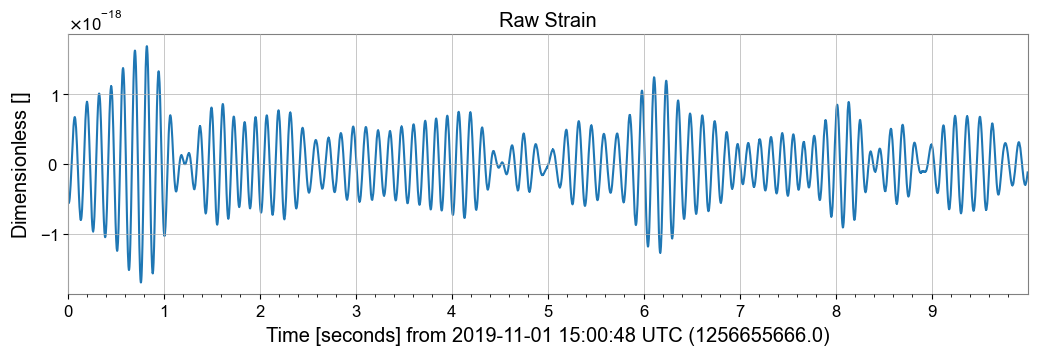

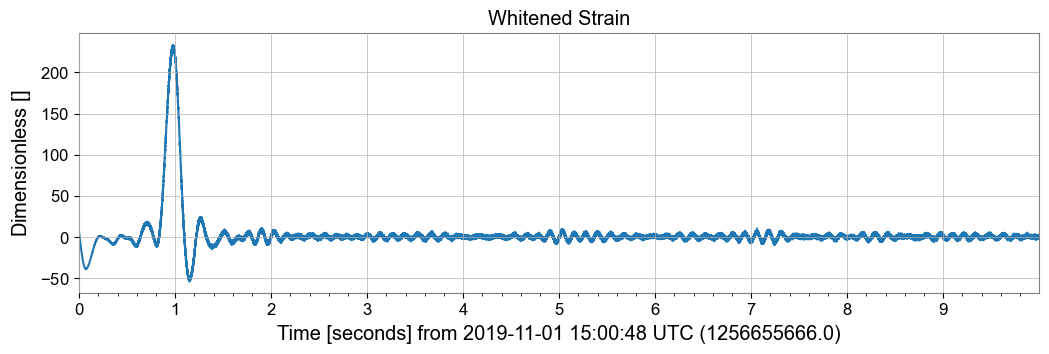

In [24]:
# Reading time series data
ts = TimeSeries.read(
    source=gwf_file,
    channel=channel,
    start=start,
    end=end,
)
ts[:10*sample_rate].plot(title='Raw Strain').show()

# Calculating ASD
fftlength = 32
overlap = fftlength/2
asd = ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)

# Whiten time series data
wh_ts = ts.whiten(asd=asd)
wh_ts[:10*sample_rate].plot(title='Whitened Strain').show()

### Get Spectrogram

Time: 1256656115.644531, Frequency: 42.33227450091618, SNR: 30.338991355505463


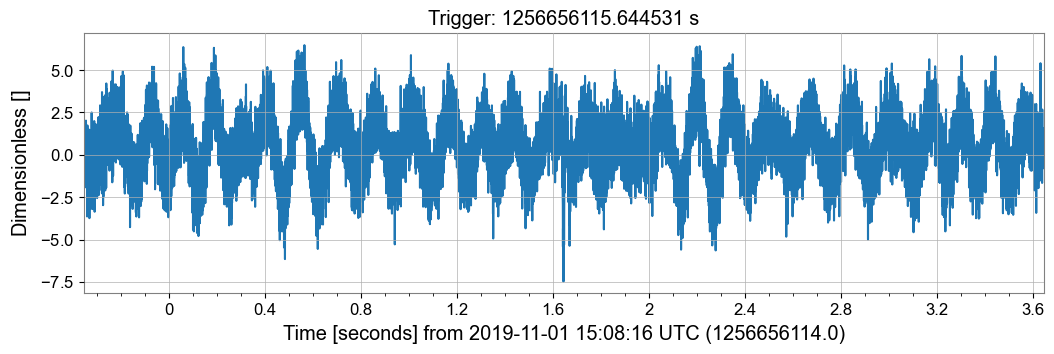

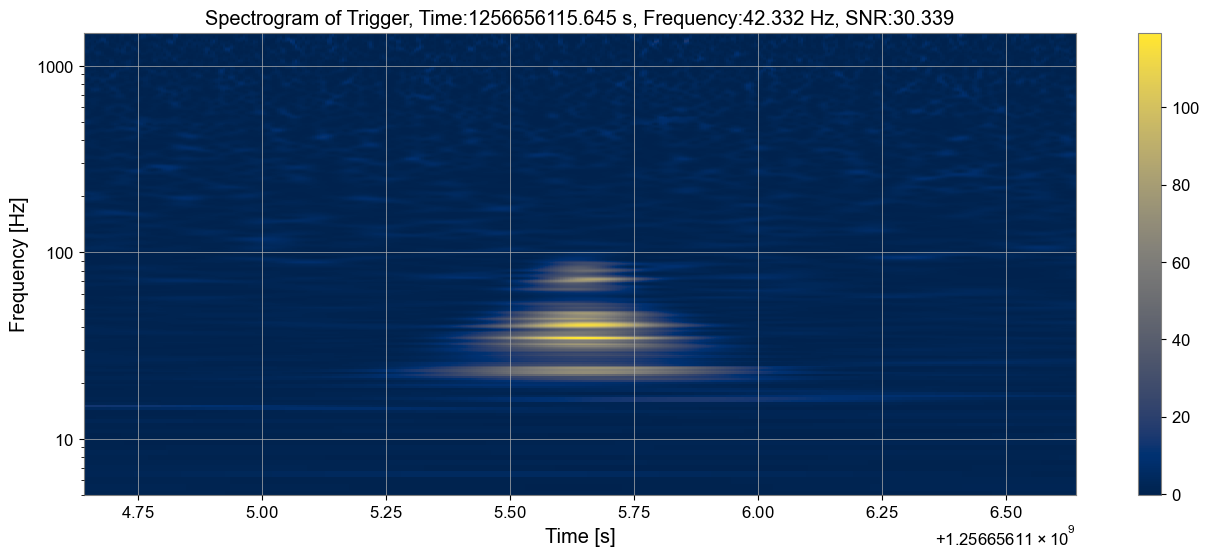

In [25]:
# Crop the time series first and then calculate the spectrogram
trigger_info_file = f"{output_dir}/triggers_merge_{channel.replace(':', '_', 1)}-{chosen_seg[1]}-{chosen_seg[1]-chosen_seg[0]}.hdf5"
with h5py.File(trigger_info_file, 'r') as f:
    trigger_times = f['triggers']['time'][:]
    trigger_frequenciess = f['triggers']['frequency'][:]
    trigger_snrs = f['triggers']['snr'][:]


id = 21
trigger_time = trigger_times[id]
trigger_frequency = trigger_frequencies[id]
trigger_snr = trigger_snrs[id]
print(f"Time: {trigger_time}, Frequency: {trigger_frequency}, SNR: {trigger_snr}")

# Crop time series data
duration = 2
crop_head, crop_tail = 1, 1
t0 = trigger_time - (duration/2 + crop_head)
crop_ts = wh_ts.crop(t0, t0+duration+crop_head+crop_tail)
crop_ts.plot(title=f"Trigger: {trigger_time} s").show()

# Q-transform
qspec_short = crop_ts.q_transform(
    qrange=(50,50),
    frange=(5, 1500),
    tres=1/200,
    # logf=True,
    # fres=200,
    logf=False,
    fres=0.5,
    whiten=False,
)
qspec_view = qspec_short.crop(trigger_time-duration/2, trigger_time+duration/2)
amplitude = qspec_view.T.to_value()
times = qspec_view.times.to_value()
frequencies = qspec_view.frequencies.to_value()
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram of Trigger, Time:{trigger_time:.3f} s, Frequency:{trigger_frequency:.3f} Hz, SNR:{trigger_snr:.3f}")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    # vmax=20,
    cmap='cividis',
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.yscale('log')
plt.ylim([5, 1500])
plt.colorbar(cmap='cividis')
plt.show()

### Workflow of Calculating Spectrograms and Save to a hdf5 File

In [26]:
# Define a function to get the asd for whitening
def calculate_asd(
        source: list,
        channel: str,
        start: float,
        end: float,
        fftlength: float=32,
        overlap: float=16,
):
    ts = TimeSeries.read(
        source=source,
        channel=channel,
        start=start,
        end=end,
    )
    asd = ts.asd(
        fftlength=fftlength,
        overlap=overlap,
        method='median',
    )
    return asd

# Define a function to get all of the spectrogram
def calculate_spectrogram(
        source: list,
        channel: str,
        trigger_info,
        asd,
        window_length: float=2,
        crop_length: float=1,
        offset: float=0,
        qrange: tuple=(50,50),
        frange: tuple=(5, 1500),
        tres: float=1/200,
        fres: float=0.5,
):
    trigger_time = trigger_info['time']
    start = trigger_time - (window_length/2 + crop_length) + offset
    end = trigger_time + (window_length/2 + crop_length) + offset
    ts = TimeSeries.read(
        source=source,
        channel=channel,
        start=start,
        end=end,
    )
    wh_ts = ts.whiten(asd=asd)
    qspec = wh_ts.q_transform(
        qrange=qrange,
        frange=frange,
        tres=tres,
        logf=False,
        fres=fres,
        whiten=False,
    )
    qspec_crop = qspec.crop(start+crop_length, end-crop_length)
    return qspec_crop

def save_spectrogram(
        output_file: str,
        qspecs,
        trigger_info,
):
    amplitudes = np.stack([qspec.T.value for qspec in qspecs])
    times = np.stack([qspec.times.value for qspec in qspecs])
    frequencies = np.stack([qspec.frequencies.value for qspec in qspecs])
    with h5py.File(output_file, 'w') as f:
        f.create_dataset(
            "amplitude",
            shape=amplitudes.shape,
            dtype=amplitudes.dtype,
            data=amplitudes,
        )
        f.create_dataset(
            "times",
            shape=times.shape,
            dtype=times.dtype,
            data=times,
        )
        f.create_dataset(
            "frequencies",
            shape=frequencies.shape,
            dtype=frequencies.dtype,
            data=frequencies,
        )
        f.create_dataset(
            "trigger_info",
            shape=trigger_info.shape,
            dtype=trigger_info.dtype,
            data=trigger_info,
        )

    return

<class 'numpy.ndarray'>
[('time', '<f8'), ('frequency', '<f8'), ('tstart', '<f8'), ('tend', '<f8'), ('fstart', '<f8'), ('fend', '<f8'), ('snr', '<f8'), ('q', '<f8'), ('amplitude', '<f8'), ('phase', '<f8')]
(2990, 400)


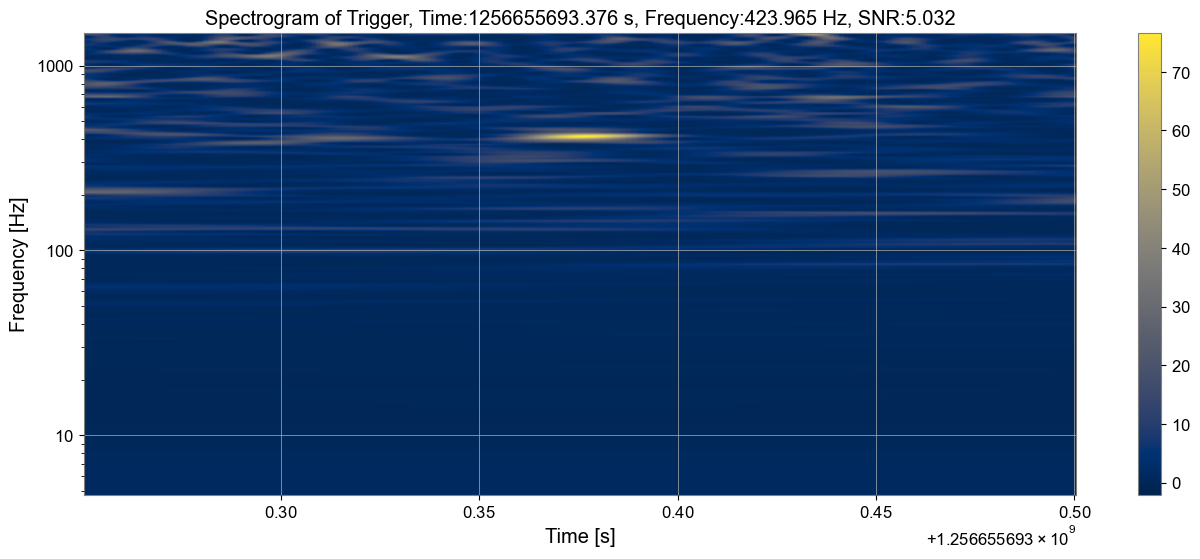

(2990, 400)


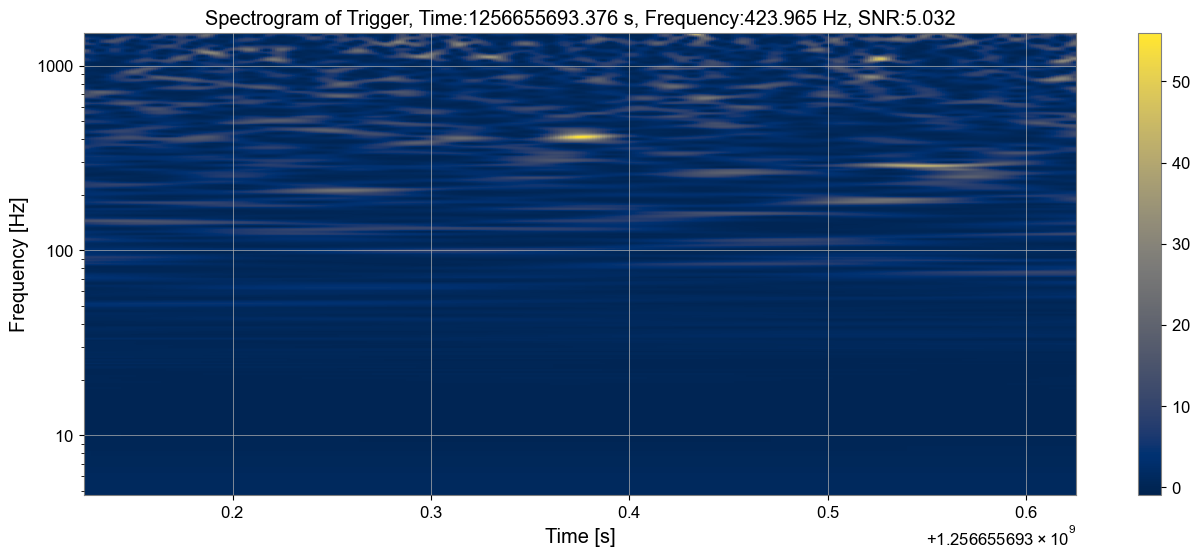

(2990, 400)


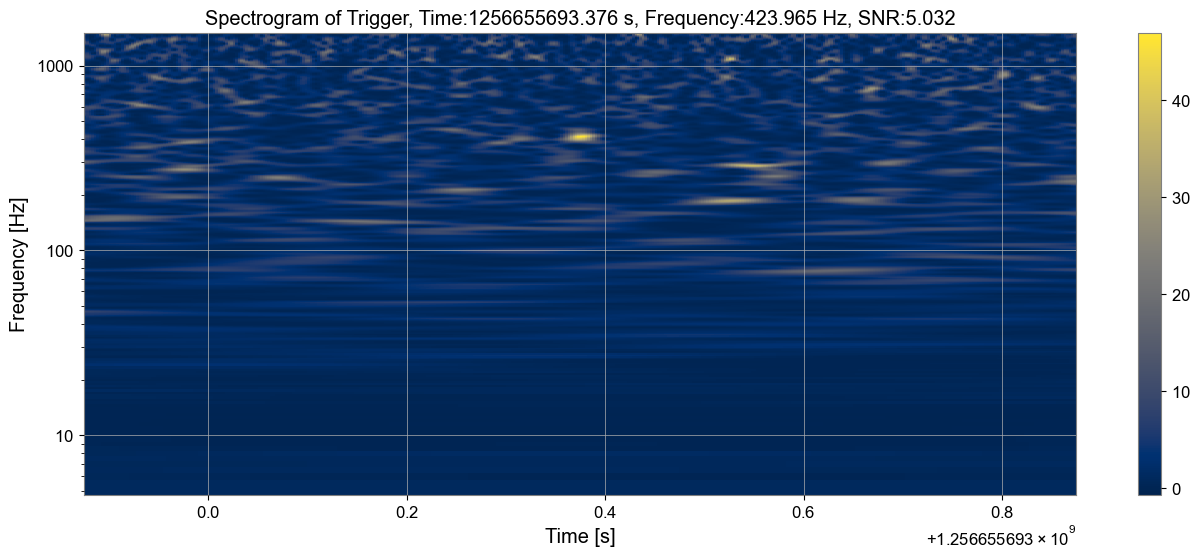

(2990, 400)


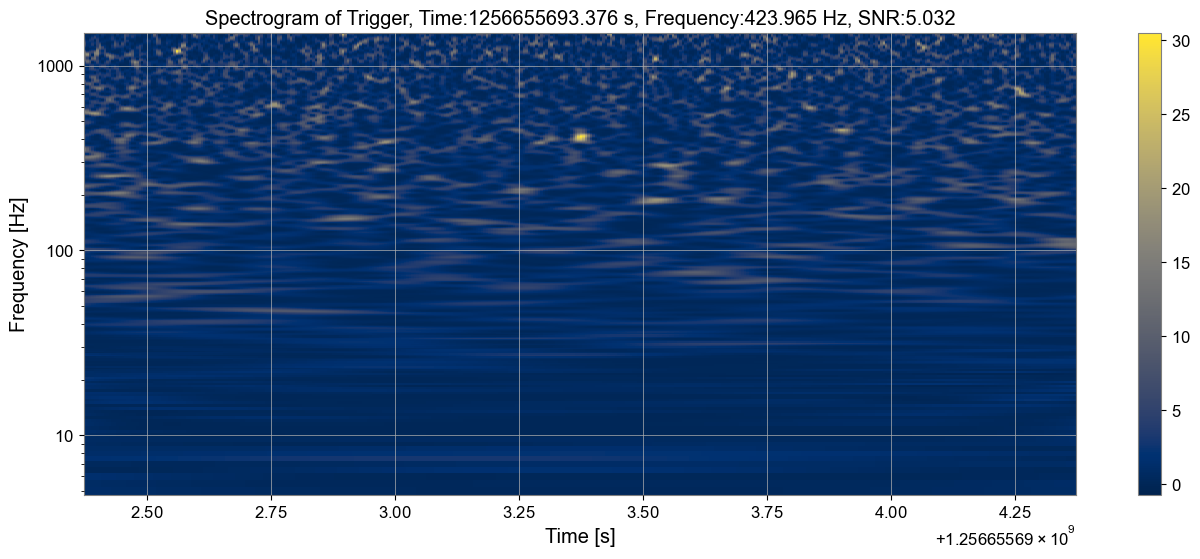

In [45]:
# Specify the information about the time series data and the triggers
ifo = "L1"
source = glob.glob(f"{data_dir}/{ifo[0]}-{ifo}_*.gwf")
channel = frtools.get_channels(source[0])[0]
trigger_info_file = f"{output_dir}/triggers_merge_{channel.replace(':', '_', 1)}-{chosen_seg[1]}-{chosen_seg[1]-chosen_seg[0]}.hdf5"
with h5py.File(trigger_info_file, 'r') as f:
    trigger_info = f['triggers'][:]

print(type(trigger_info))
print(trigger_info.dtype)

# Calculate asds
start = 1256655666
duration = 2073
end = start + duration
asd = calculate_asd(
    source=source,
    channel=channel,
    start=start,
    end=end,
    fftlength=fftlength,
    overlap=overlap,
)

# Calculate spectrograms
window_lengths = [0.25, 0.5, 1, 2]
merged_specs = []
trigger_id_st, trigger_id_ed = 0, 1
for trigger in trigger_info[trigger_id_st:trigger_id_ed]:
    output_qspecs = []
    for window_length in window_lengths:
        crop_length = 1
        offset = 0.0*window_length
        pixel_length = 400
        qrange = (50, 50)
        frange = (5, 1500)
        tres = window_length/pixel_length
        fres = 0.5

        trigger_time = trigger['time']
        trigger_frequency = trigger['frequency']
        trigger_snr = trigger['snr']
        qspec = calculate_spectrogram(
            source=source,
            channel=channel,
            trigger_info=trigger,
            asd=asd,
            window_length=window_length,
            crop_length=crop_length,
            offset=offset,
            qrange=qrange,
            frange=frange,
            tres=tres,
            fres=fres,
        )
        output_qspecs.append(qspec)

    # Inspect spectrograms:
    for output in output_qspecs:
        amplitude = output.T.value
        times = output.times.value
        frequencies = output.frequencies.value
        print(amplitude.shape)
        plt.figure(figsize=[16,6])
        plt.title(f"Spectrogram of Trigger, Time:{trigger_time:.3f} s, Frequency:{trigger_frequency:.3f} Hz, SNR:{trigger_snr:.3f}")
        plt.pcolormesh(
            times,
            frequencies,
            amplitude,
            cmap='cividis',
        )
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")
        plt.yscale('log')
        # plt.ylim([5, 1500])
        plt.colorbar(cmap='cividis')
        plt.show()

    # Merge 4 kinds of the spectrograms:
    qspec_row_n = output_qspecs[0].T.value.shape[0]
    qspec_column_n = output_qspecs[0].T.value.shape[1]
    # print(qspec_column_n, qspec_row_n)
    data_shape = (2*qspec_column_n, 2*qspec_row_n)
    blank = np.zeros(shape=data_shape)
    # print(blank.shape)
    blank[:qspec_column_n, :qspec_row_n] = output_qspecs[0].value
    blank[:qspec_column_n, qspec_row_n:] = output_qspecs[1].value
    blank[qspec_column_n:, :qspec_row_n] = output_qspecs[2].value
    blank[qspec_column_n:, qspec_row_n:] = output_qspecs[3].value
    merged_spec = blank

    # Append the spectrogram to a list merged_specs
    merged_specs.append(merged_spec)

    # Inspect merged spectrogram:
    # chosen_spec = merged_specs[0]
    # plt.figure(figsize=[16,6])
    # plt.pcolormesh(
    #     chosen_spec.T,
    #     cmap='cividis',
    # )
    # plt.colorbar(cmap='cividis')
    # plt.show()

# Save the information of the triggers and their spectrograms
output_file = f"./Data/{ifo}_qspecs-{start}-{duration}.hdf5"
with h5py.File(output_file, 'w') as f:
    # Saving trigger info:
    trigger_data = np.stack(trigger_info[trigger_id_st:trigger_id_ed])
    f.create_dataset(
        "triggers",
        shape=trigger_data.shape,
        dtype=trigger_data.dtype,
        data=trigger_data,
    )
    # Saving merged spectrograms:
    qspec_data = np.stack(merged_specs)
    f.create_dataset(
        "qspecs",
        shape=qspec_data.shape,
        dtype=qspec_data.dtype,
        data=qspec_data,
    )
    f['qspecs'].attrs['channel'] = channel
    f['qspecs'].attrs['window_lengths'] = window_lengths
    f['qspecs'].attrs['qrange'] = np.array(qrange)
    f['qspecs'].attrs['frange'] = np.array(frange)
    f['qspecs'].attrs['tres'] = tres
    f['qspecs'].attrs['fres'] = fres

<KeysViewHDF5 ['qspecs', 'triggers']>
[0.25 0.5  1.   2.  ]
[50 50]
[   5 1500]
0.005
0.5


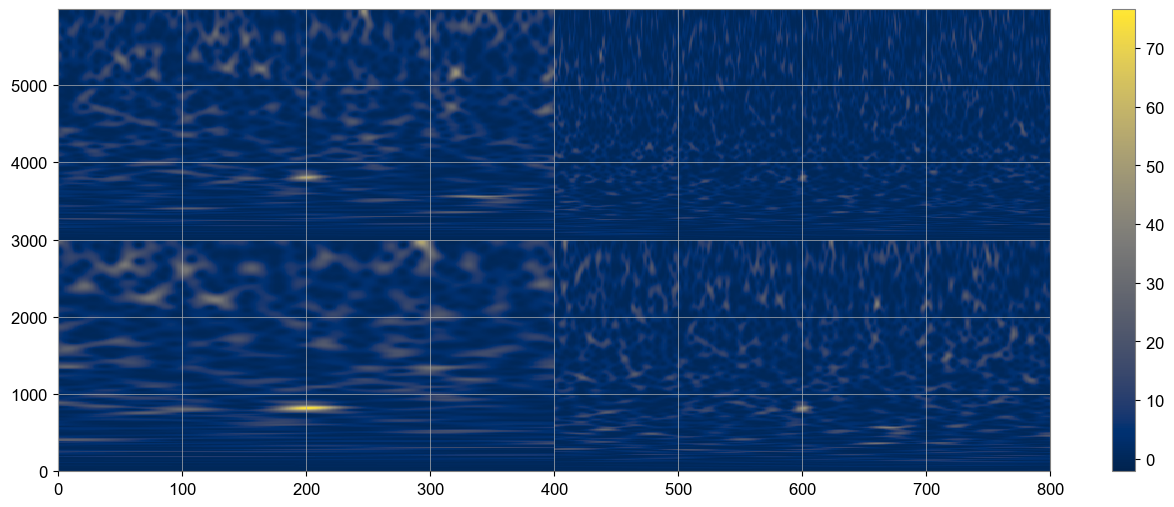

In [ ]:
# Check the data in the written file:
with h5py.File(output_file, 'r') as f:
    print(f.keys())
    trigger_info = f['triggers'][:]
    qspecs = f['qspecs'][:]
    print(f['qspecs'].attrs['window_lengths'])
    print(f['qspecs'].attrs['qrange'])
    print(f['qspecs'].attrs['frange'])
    print(f['qspecs'].attrs['tres'])
    print(f['qspecs'].attrs['fres'])

chosen_spec = qspecs[0]
plt.figure(figsize=[16,6])
plt.title(f"{}")
plt.pcolormesh(
    chosen_spec.T,
    cmap='cividis',
)
plt.colorbar(cmap='cividis')
plt.show()

In [ ]:
print(trigger_snrs)
for i, snr in enumerate(trigger_snrs):
    if snr >= 100:
        print(i, snr)

[5.032229604127074, 44.40856106795152, 5.667487115351235, 8.80533455939033, 5.064844053021606, 9.162215900413171, 5.100228550345878, 9.117858446062034, 6.583309332701542, 6.337798281880494, 10.6039293440067, 104.147084391904, 10.319432777165126, 5.023766275198698, 5.358843429681596, 5.18188731955069, 5.045738558989289, 5.191920682069558, 5.132395045364208, 315.785014125254, 7.061805892207992, 30.338991355505236, 5.4202499056119935, 5.195136813471443, 5.230469272226459, 5.261548759377985, 5.044314196720507, 5.794337544053471, 5.60817108014871, 5.062899698318892, 5.0075053056701515, 5.025435127787002, 6.71068784184045, 5.111267727532588, 16.559937797007034, 5.125172612432482, 8.20980984360255, 64.63358404504501, 117.05658400737626, 5.0764735320290075, 5.065398636540723, 5.391072212065601, 5.063648747526636, 11.472420253652482, 5.303867776206812, 5.368959565104804, 5.311264412007554, 5.242519101905582, 5.200066435067701, 5.969666208652118, 5.010686146566114, 5.270293239208071, 5.062264919